In [ ]:
from transformers import BertForSequenceClassification
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch
import pandas as pd
import torch
from transformers import AutoTokenizer
import ast  # For safely evaluating stringified lists
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from transformers import BertTokenizer, BertForSequenceClassification
from torch.optim import AdamW
import torch
from torch.utils.data import DataLoader, Dataset

In [118]:
# Device Check
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Using Apple Silicon (MPS)")
elif torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"Using GPU: {torch.cuda.get_device_name(0)}")
else:
    device = torch.device("cpu")
    print("Using CPU (training will be slower)")

Using Apple Silicon (MPS)


In [120]:
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8)

In [124]:
# Load tokenizer and model
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=3)
model.to(device)



Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


RuntimeError: MPS backend out of memory (MPS allocated: 18.15 GB, other allocations: 816.00 KB, max allowed: 18.13 GB). Tried to allocate 89.42 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).

In [122]:
optimizer = AdamW(model.parameters(), lr=2e-5)
loss_fn = nn.CrossEntropyLoss()


In [125]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=2,
    per_device_train_batch_size=4,   # reduced
    per_device_eval_batch_size=8,    # reduced
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir="./logs",
    eval_strategy="epoch",
    logging_steps=10,
    save_strategy="epoch"
)

In [126]:
model.train()
for epoch in range(3):
    total_loss = 0
    for batch in train_loader:
        input_ids = batch['input_ids'].to(device, dtype=torch.long)
        attention_mask = batch['attention_mask'].to(device, dtype=torch.long)
        labels = batch['labels'].to(device, dtype=torch.long)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch + 1} completed. Avg Loss: {avg_loss:.4f}")


/var/folders/vh/hr9w_0vd1xv4xfslxfhrwmxh0000gn/T/ipykernel_29693/2175986362.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx], dtype=torch.long) for key, val in self.encodings.items()}
/var/folders/vh/hr9w_0vd1xv4xfslxfhrwmxh0000gn/T/ipykernel_29693/2175986362.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item['labels'] = torch.tensor(self.labels[idx], dtype=torch.long)


RuntimeError: MPS backend out of memory (MPS allocated: 18.15 GB, other allocations: 816.00 KB, max allowed: 18.13 GB). Tried to allocate 32.00 KB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).

In [77]:
class ReviewDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = {
            key: torch.stack(val).to(torch.int64) for key, val in encodings.items()
        }
        self.labels = labels.to(torch.long)

    def __getitem__(self, idx):
        return {
            "input_ids": self.encodings["input_ids"][idx],
            "attention_mask": self.encodings["attention_mask"][idx],
            "token_type_ids": self.encodings["token_type_ids"][idx],
            "labels": self.labels[idx]
        }

    def __len__(self):
        return len(self.labels)


In [87]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
)


In [88]:
for name, param in model.bert.named_parameters():
    if "encoder.layer.0" in name or "encoder.layer.1" in name:
        param.requires_grad = False


In [89]:
from torch.utils.data import Dataset
import torch

class ReviewDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx], dtype=torch.long) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item

    def __len__(self):
        return len(self.labels)


In [128]:
# Train the Model
trainer.train()

AttributeError: `AcceleratorState` object has no attribute `distributed_type`. This happens if `AcceleratorState._reset_state()` was called and an `Accelerator` or `PartialState` was not reinitialized.

In [ ]:
from sklearn.metrics import classification_report

# Get predictions from your trained model
predictions = trainer.predict(test_dataset)
y_pred = predictions.predictions.argmax(-1)
y_true = predictions.label_ids

# Define class names
target_names = ['recommended', 'Not recommended', 'Neutral']

# Print the report
print(classification_report(y_true, y_pred, target_names=target_names))


/opt/anaconda3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


                 precision    recall  f1-score   support

    recommended       1.00      0.99      0.99       144
Not recommended       1.00      1.00      1.00       139
        Neutral       0.99      1.00      0.99       149

       accuracy                           1.00       432
      macro avg       1.00      1.00      1.00       432
   weighted avg       1.00      1.00      1.00       432



In [124]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

In [125]:
model.save_pretrained("./sentiment_model")
tokenizer.save_pretrained("./sentiment_model")


('./sentiment_model/tokenizer_config.json',
 './sentiment_model/special_tokens_map.json',
 './sentiment_model/vocab.txt',
 './sentiment_model/added_tokens.json',
 './sentiment_model/tokenizer.json')

/opt/anaconda3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


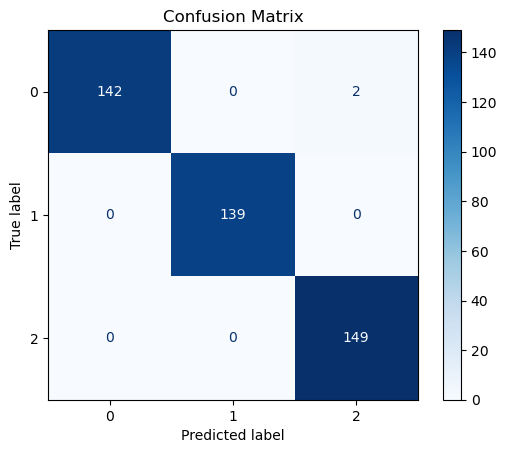

In [114]:
# Generate confusion matrix
predictions = trainer.predict(test_dataset)
preds = np.argmax(predictions.predictions, axis=1)
labels = predictions.label_ids

# Compute confusion matrix
cm = confusion_matrix(labels, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()
